# Анализ работы онлайн магазина

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

In [2]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-p-artemov/My_project/Commerce/data.csv',  encoding='windows-1251', sep = ',')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [5]:
df.InvoiceDate = pd.to_datetime(df.InvoiceDate)
df.CustomerID = pd.Series(df.CustomerID, dtype = "object")

In [6]:
df.shape

(541909, 8)

In [7]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


#### Видим, что присутствуют значения количества товаров в заказе и цена с отрицательным значением. Примем это как значения отмененных заказов

In [8]:
df.InvoiceDate.min()

Timestamp('2010-12-01 08:26:00')

In [9]:
df.InvoiceDate.max()

Timestamp('2011-12-09 12:50:00')

In [10]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## Количество товаров в чеке и размер чека совершившихся покупок

In [11]:
df['Price'] = df.Quantity * df.UnitPrice

In [12]:
total_quantity_price_by_invoice = df.groupby('InvoiceNo', as_index = False)\
                                    .agg({"Quantity" : "sum", "Price" : "sum"})\
                                    .query("Quantity > 0 and Price>0")

In [13]:
total_quantity_price_by_invoice.head()

,InvoiceNo,Quantity,Price
0,536365,40,139.12
1,536366,12,22.20
2,536367,83,278.73
3,536368,15,70.05
4,536369,3,17.85


In [14]:
total_income = total_quantity_price_by_invoice.Price.sum()

In [15]:
total_income

10666684.544

### Найдем средний чек 

In [16]:
mean_check = total_quantity_price_by_invoice.Price.mean()

In [17]:
mean_check

534.403033266533

### Найдем количество отмененных транзакций

In [18]:
count_cancel  = df.query("Quantity < 0 or UnitPrice<0")\
                  .groupby('InvoiceNo', as_index = False)\
                  .agg({"Quantity" : "sum"})\
                  .InvoiceNo.count()

In [19]:
count_cancel

5174

### Найдем количество потерянных денег по отмененным заказам

In [20]:
lost_money = df.query("Quantity < 0 or Price < 0")\
               .groupby('InvoiceNo', as_index = False)\
               .agg({"Price" : "sum"})\
               .Price.sum()*(-1)

In [21]:
lost_money

918936.61

In [22]:
procent_lost_money = round((lost_money/total_income)*100,2)

In [23]:
procent_lost_money

8.62

### Заработанные деньги

In [24]:
total_income-lost_money

9747747.934

### Найдем количество купленных товаров по видам и прибыль по ним

In [25]:
df.query("Quantity > 0 and Price>0")\
  .groupby("StockCode", as_index = False)\
  .agg({'Quantity' : 'sum', 'Price' : 'sum'})\
  .sort_values(["Quantity", 'Price'], ascending = False)

,StockCode,Quantity,Price
2465,23843,80995,168469.60
2020,23166,78033,81700.92
1109,22197,56921,51354.02
2909,84077,55047,13841.85
3387,85099B,48474,94340.05
...,...,...,...
3106,84743C,1,1.25
3265,84977,1,1.25
3666,90084,1,0.85
2714,51014c,1,0.83


## Посмотрим прибыль по странам, с учетом отмененных транзакций

In [26]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [27]:
df.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [28]:
df_country = df.groupby("Country", as_index = False)\
               .agg({'Quantity' : 'sum', 'Price' : 'sum'})\
               .sort_values('Price', ascending = False)

In [29]:
df_country

,Country,Quantity,Price
36,United Kingdom,4263829,8.187806e+06
24,Netherlands,200128,2.846615e+05
10,EIRE,142637,2.632768e+05
14,Germany,117448,2.216982e+05
13,France,110480,1.974039e+05
0,Australia,83653,1.370773e+05
33,Switzerland,30325,5.638535e+04
31,Spain,26824,5.477458e+04
3,Belgium,23152,4.091096e+04
32,Sweden,35637,3.659591e+04


Text(0.5, 1.0, 'Топ-10 стран по полученной прибыли')

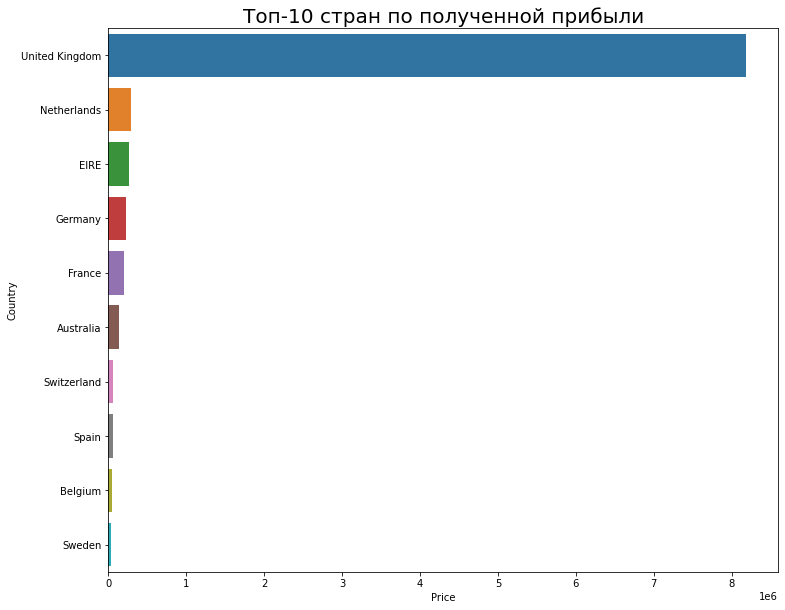

In [117]:
sns.barplot(data = df_country.head(10) , y = 'Country', x = 'Price')\
            .set_title('Топ-10 стран по полученной прибыли', fontdict = { 'fontsize': 20})

Text(0.5, 1.0, 'Топ-10 стран по кол-ву выкупленных товаров')

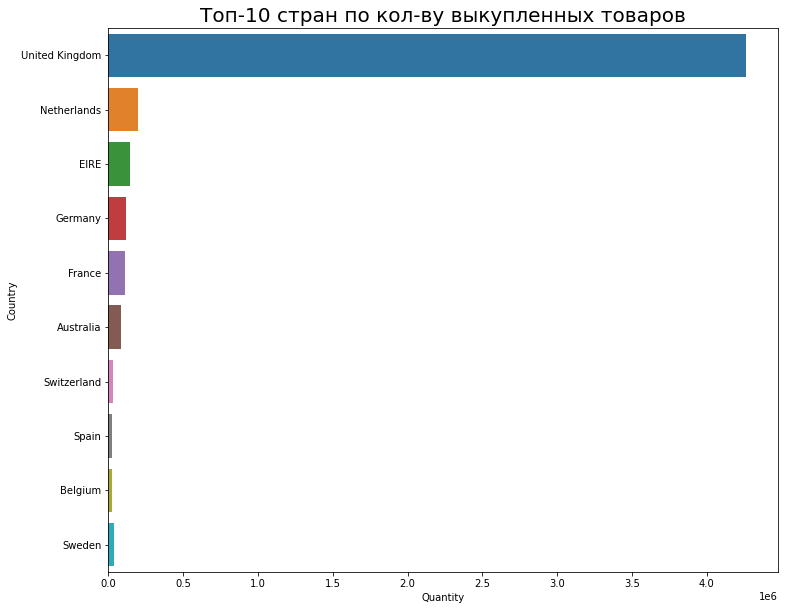

In [116]:
sns.barplot(data = df_country.head(10) , y = 'Country', x = 'Quantity')\
            .set_title('Топ-10 стран по кол-ву выкупленных товаров', fontdict = { 'fontsize': 20})

## Посмотрим в какой день недели сколько было выполнено транзакций (за исключением возвратов)

In [32]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [33]:
df['Week_day'] = df.InvoiceDate.dt.day_name()

In [34]:
df_week_day = df.query("Quantity > 0 and Price > 0")\
                .groupby('Week_day', as_index = False)\
                .agg({'InvoiceNo' : 'count'})\
                .sort_values('InvoiceNo', ascending = False)

Text(0.5, 1.0, 'Количество заказов по дням недели')

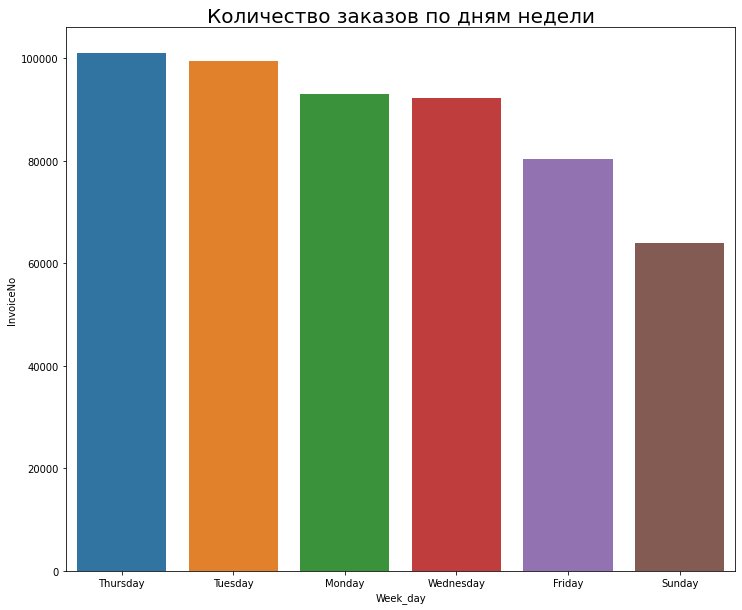

In [115]:
sns.barplot(data = df_week_day, y = 'InvoiceNo', x = 'Week_day')\
            .set_title('Количество заказов по дням недели', fontdict = { 'fontsize': 20})

## Когортный анализ retention

In [36]:
df_cohorts = df.query("Quantity > 0 and Price > 0")[['CustomerID', 'InvoiceDate']]

In [37]:
df_cohorts['date'] =  df_cohorts.InvoiceDate.dt.strftime('%Y-%m')

In [38]:
df_cohorts

,CustomerID,InvoiceDate,date
0,17850,2010-12-01 08:26:00,2010-12
1,17850,2010-12-01 08:26:00,2010-12
2,17850,2010-12-01 08:26:00,2010-12
3,17850,2010-12-01 08:26:00,2010-12
4,17850,2010-12-01 08:26:00,2010-12
...,...,...,...
541904,12680,2011-12-09 12:50:00,2011-12
541905,12680,2011-12-09 12:50:00,2011-12
541906,12680,2011-12-09 12:50:00,2011-12
541907,12680,2011-12-09 12:50:00,2011-12


In [39]:
df_cohorts.dropna()

,CustomerID,InvoiceDate,date
0,17850,2010-12-01 08:26:00,2010-12
1,17850,2010-12-01 08:26:00,2010-12
2,17850,2010-12-01 08:26:00,2010-12
3,17850,2010-12-01 08:26:00,2010-12
4,17850,2010-12-01 08:26:00,2010-12
...,...,...,...
541904,12680,2011-12-09 12:50:00,2011-12
541905,12680,2011-12-09 12:50:00,2011-12
541906,12680,2011-12-09 12:50:00,2011-12
541907,12680,2011-12-09 12:50:00,2011-12


In [40]:
df_first_date = df.query("Quantity > 0 and Price > 0")[['CustomerID', 'InvoiceDate']]\
                  .groupby('CustomerID', as_index = False)\
                  .agg({'InvoiceDate' : 'min'})

In [41]:
df_first_date['First_buy_date'] = df_first_date.InvoiceDate.dt.strftime('%Y-%m')

In [42]:
df_first_date = df_first_date[['CustomerID', 'First_buy_date']]

In [43]:
df_first_date.isna().sum()

CustomerID        0
First_buy_date    0
dtype: int64

In [44]:
df_cohorts = df_cohorts.merge(df_first_date, on = 'CustomerID')

In [45]:
df_cohorts = df_cohorts[['CustomerID', 'date', 'First_buy_date']]

In [46]:
df_cohorts = df_cohorts.groupby(['First_buy_date', 'date'])\
                       .agg({'CustomerID' : 'nunique'})

In [47]:
df_cohorts

CustomerID
First_buy_date date               
2010-12        2010-12         885
               2011-01         324
               2011-02         286
               2011-03         340
               2011-04         321
...                            ...
2011-10        2011-11          86
               2011-12          41
2011-11        2011-11         323
               2011-12          36
2011-12        2011-12          41

[91 rows x 1 columns]

In [48]:
df_cohort_size = df_cohorts.groupby(level = 'First_buy_date')\
                           .agg({'CustomerID' : 'first'})

In [49]:
df_cohort_size.columns = ['Cohort_size']

In [50]:
df_cohort_size

,Cohort_size
First_buy_date,
2010-12,885
2011-01,417
2011-02,380
2011-03,452
2011-04,300
2011-05,284
2011-06,242
2011-07,188
2011-08,169


In [51]:
df_cohorts = df_cohorts.join(df_cohort_size, on = "First_buy_date")

In [52]:
df_cohorts

CustomerID  Cohort_size
First_buy_date date                            
2010-12        2010-12         885          885
               2011-01         324          885
               2011-02         286          885
               2011-03         340          885
               2011-04         321          885
...                            ...          ...
2011-10        2011-11          86          358
               2011-12          41          358
2011-11        2011-11         323          323
               2011-12          36          323
2011-12        2011-12          41           41

[91 rows x 2 columns]

In [53]:
df_cohorts['retencion'] = round(df_cohorts.CustomerID / df_cohorts.Cohort_size,3)

In [54]:
df_cohorts

CustomerID  Cohort_size  retencion
First_buy_date date                                       
2010-12        2010-12         885          885      1.000
               2011-01         324          885      0.366
               2011-02         286          885      0.323
               2011-03         340          885      0.384
               2011-04         321          885      0.363
...                            ...          ...        ...
2011-10        2011-11          86          358      0.240
               2011-12          41          358      0.115
2011-11        2011-11         323          323      1.000
               2011-12          36          323      0.111
2011-12        2011-12          41           41      1.000

[91 rows x 3 columns]

In [55]:
df_cohorts.reset_index()\
          .pivot(index = 'First_buy_date', columns = 'date', values = 'retencion')\
          .fillna('')

date,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
First_buy_date,,,,,,,,,,,,,
2010-12,1,0.366,0.323,0.384,0.363,0.398,0.363,0.349,0.354,0.395,0.374,0.503,0.266
2011-01,,1,0.221,0.266,0.23,0.321,0.288,0.247,0.242,0.3,0.326,0.365,0.118
2011-02,,,1,0.187,0.187,0.284,0.271,0.247,0.253,0.279,0.247,0.305,0.068
2011-03,,,,1,0.15,0.252,0.199,0.223,0.168,0.268,0.23,0.279,0.086
2011-04,,,,,1,0.213,0.203,0.21,0.197,0.227,0.217,0.26,0.073
2011-05,,,,,,1,0.19,0.173,0.173,0.208,0.232,0.264,0.095
2011-06,,,,,,,1,0.174,0.157,0.264,0.231,0.335,0.095
2011-07,,,,,,,,1,0.181,0.207,0.223,0.271,0.112
2011-08,,,,,,,,,1,0.207,0.249,0.243,0.124


## RFM - сегментация

In [56]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price,Week_day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Wednesday


In [57]:
df_customer = df.query("Quantity > 0 and Price > 0")\
                .groupby('CustomerID', as_index = False)\
                .agg({'Quantity' : 'sum', 'Price' : 'sum', 'InvoiceDate' : 'max'})

In [58]:
last_date = df.InvoiceDate.max()

In [59]:
last_date

Timestamp('2011-12-09 12:50:00')

In [60]:
rfmtable = df.query("Quantity > 0 and Price > 0")\
             .groupby('CustomerID')\
             .agg({'InvoiceDate' : lambda x : (last_date - x.max()).days, 'InvoiceNo' : lambda x: len(x), 'Price' : 'sum'})

In [61]:
rfmtable.columns = ['Recency', 'Frequency', 'Monetary_value']

In [62]:
rfmtable = rfmtable.reset_index()

In [63]:
rfmtable['CustomerID'] = rfmtable['CustomerID'].astype(int)

In [64]:
rfmtable

,CustomerID,Recency,Frequency,Monetary_value
0,12346,325,1,77183.60
1,12347,1,182,4310.00
2,12348,74,31,1797.24
3,12349,18,73,1757.55
4,12350,309,17,334.40
...,...,...,...,...
4333,18280,277,10,180.60
4334,18281,180,7,80.82
4335,18282,7,12,178.05
4336,18283,3,756,2094.88


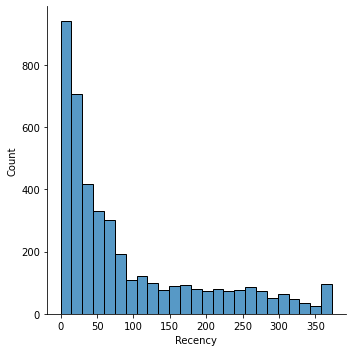

In [102]:
sns.displot(rfmtable.Recency)

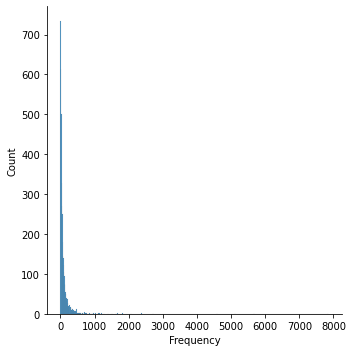

In [103]:
sns.displot(rfmtable.Frequency)

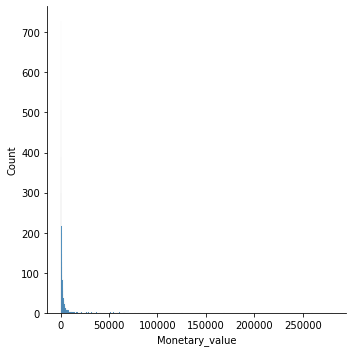

In [104]:
sns.displot(rfmtable.Monetary_value)

In [68]:
quantiles = rfmtable[['Recency', 'Frequency', 'Monetary_value']].quantile([.25, .5, .75]).to_dict()

In [69]:
quantiles

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 141.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 100.0},
 'Monetary_value': {0.25: 307.41499999999996,
  0.5: 674.4849999999999,
  0.75: 1661.7400000000007}}

In [70]:
def RClass(value,parameter_name,quantiles):
    if value <= quantiles[parameter_name][0.25]:
        return 1
    elif value <= quantiles[parameter_name][0.50]:
        return 2
    elif value <= quantiles[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles):
    if value <= quantiles[parameter_name][0.25]:
        return 4
    elif value <= quantiles[parameter_name][0.50]:
        return 3
    elif value <= quantiles[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [71]:
rfmtable['R_Quartile'] = rfmtable['Recency'].apply(RClass, args=('Recency',quantiles))
rfmtable['F_Quartile'] = rfmtable['Frequency'].apply(FMClass, args=('Frequency',quantiles))
rfmtable['M_Quartile'] = rfmtable['Monetary_value'].apply(FMClass, args=('Monetary_value',quantiles))
rfmtable['RFMClass'] = rfmtable.R_Quartile.map(str) + rfmtable.F_Quartile.map(str) + rfmtable.M_Quartile.map(str)

In [72]:
rfmtable

,CustomerID,Recency,Frequency,Monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,12346,325,1,77183.60,4,4,1,441
1,12347,1,182,4310.00,1,1,1,111
2,12348,74,31,1797.24,3,3,1,331
3,12349,18,73,1757.55,2,2,1,221
4,12350,309,17,334.40,4,4,3,443
...,...,...,...,...,...,...,...,...
4333,18280,277,10,180.60,4,4,4,444
4334,18281,180,7,80.82,4,4,4,444
4335,18282,7,12,178.05,1,4,4,144
4336,18283,3,756,2094.88,1,1,1,111


Посмотрим как в зависимости от сегментации частоты транзакций клиентов и количества покупок изменяется прибыль от клиентов в этом сегменте

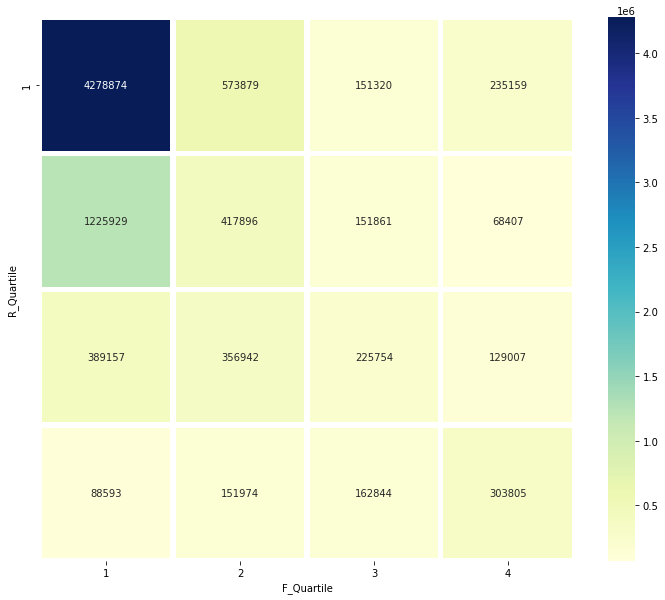

In [73]:
rfm_table = rfmtable.pivot_table(
                    index='R_Quartile', 
                    columns='F_Quartile', 
                    values='Monetary_value', 
                    aggfunc=np.sum).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4)

## Подсчет ARPPU

In [74]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price,Week_day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Wednesday
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,Friday
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,Friday
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,Friday
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,Friday


In [75]:
df["month"] = df.InvoiceDate.dt.to_period("M")

In [76]:
df['Date'] = df.InvoiceDate.dt.date

In [77]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price,Week_day,month,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,Wednesday,2010-12,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Wednesday,2010-12,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,Wednesday,2010-12,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Wednesday,2010-12,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Wednesday,2010-12,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,Friday,2011-12,2011-12-09
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,Friday,2011-12,2011-12-09
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,Friday,2011-12,2011-12-09
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,Friday,2011-12,2011-12-09


In [78]:
df_ARPPU = df.groupby("Date", as_index = False)\
             .agg({"Price" : "sum", "CustomerID" : "nunique"})

In [79]:
df_ARPPU

,Date,Price,CustomerID
0,2010-12-01,58635.56,98
1,2010-12-02,46207.28,117
2,2010-12-03,45620.46,55
3,2010-12-05,31383.95,76
4,2010-12-06,53860.18,90
...,...,...,...
300,2011-12-05,57751.32,114
301,2011-12-06,54228.37,128
302,2011-12-07,75076.22,101
303,2011-12-08,81417.78,120


In [80]:
df_ARPPU["ARPPU"] = round(df_ARPPU.Price/df_ARPPU.CustomerID,2)

In [81]:
df_ARPPU.dtypes

Date           object
Price         float64
CustomerID      int64
ARPPU         float64
dtype: object

Text(0.5, 1.0, 'Изменение доходов в течении исследуемого периода')

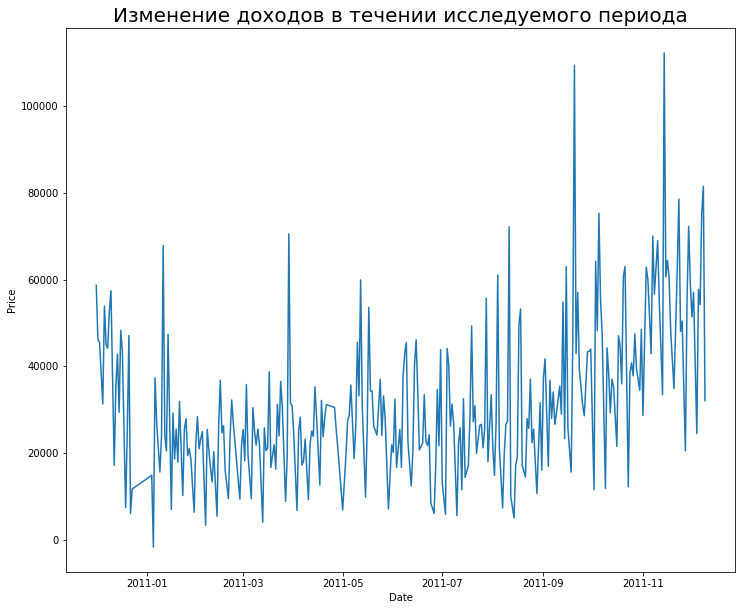

In [114]:
sns.lineplot(data = df_ARPPU, x = df_ARPPU.Date, y = "Price")\
            .set_title('Изменение доходов в течении исследуемого периода', fontdict = { 'fontsize': 20})

Text(0.5, 1.0, 'Изменение ARPPU в течении исследуемого периода')

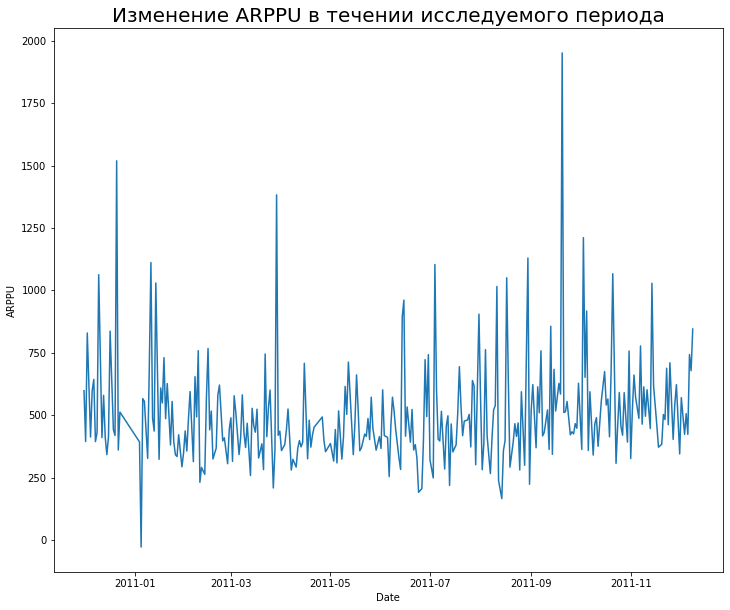

In [113]:
sns.lineplot(data = df_ARPPU, x = df_ARPPU.Date, y = "ARPPU")\
            .set_title('Изменение ARPPU в течении исследуемого периода', fontdict = { 'fontsize': 20})

## Количество возвратов по странам

In [84]:
df_country_cancel = df.query('Quantity < 0 or UnitPrice < 0')\
                      .groupby('Country', as_index = False)\
                      .agg({'InvoiceNo' : 'count'})\
                      .sort_values('InvoiceNo', ascending = False)

In [85]:
df_country_cancel = df_country_cancel.rename(columns = {'InvoiceNo' : 'Cancel_orders'})

Text(0.5, 1.0, 'Топ-10 стран по отмене заказов')

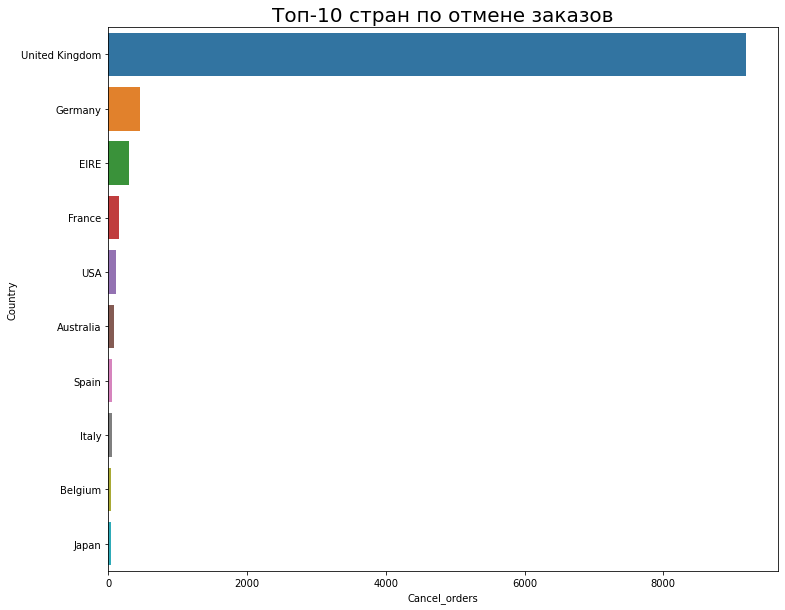

In [112]:
sns.barplot(data = df_country_cancel.head(10), y = 'Country', x = 'Cancel_orders')\
            .set_title('Топ-10 стран по отмене заказов', fontdict = { 'fontsize': 20})

In [87]:
df_country_all_Orders = df.groupby('Country', as_index = False)\
                          .agg({'InvoiceNo' : 'count'})\
                          .sort_values('InvoiceNo', ascending = False)

In [88]:
df_country_all_Orders = df_country_all_Orders.rename(columns = {'InvoiceNo' : 'All_orders'})

In [89]:
df_country_all_Orders = df_country_all_Orders.merge(df_country_cancel, on = 'Country')

In [90]:
df_country_all_Orders['Procent_cancell_orders'] = round(100 * df_country_all_Orders.Cancel_orders / df_country_all_Orders.All_orders, 2)

In [91]:
df_country_all_Orders

,Country,All_orders,Cancel_orders,Procent_cancell_orders
0,United Kingdom,495478,9194,1.86
1,Germany,9495,453,4.77
2,France,8557,149,1.74
3,EIRE,8196,302,3.68
4,Spain,2533,48,1.89
5,Netherlands,2371,8,0.34
6,Belgium,2069,38,1.84
7,Switzerland,2002,35,1.75
8,Portugal,1519,18,1.18
9,Australia,1259,74,5.88


Text(0.5, 1.0, 'Топ-10 стран по проценту отмененных заказов')

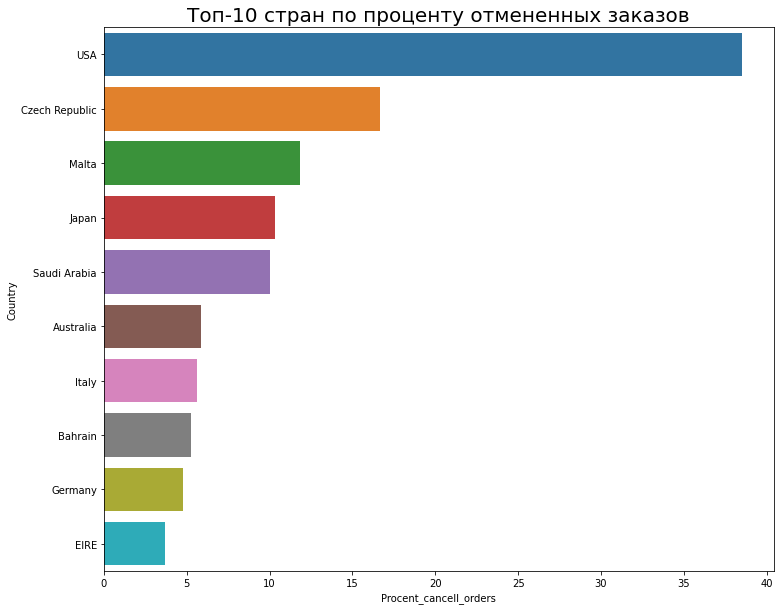

In [111]:
sns.barplot(data = df_country_all_Orders.sort_values('Procent_cancell_orders', ascending = False).head(10),\
             y = 'Country', x = 'Procent_cancell_orders')\
             .set_title('Топ-10 стран по проценту отмененных заказов', fontdict = { 'fontsize': 20})